In [1]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import tarfile
import urllib
import pandas as pd
import urllib.request

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

from sklearn.cluster import KMeans
import category_encoders as ce
from sklearn.model_selection import train_test_split

In [2]:
def load_data():
    csv_path ="./train-set.csv"
    return pd.read_csv(csv_path)

In [3]:
pd.options.display.float_format = '{:,.0f}'.format

df = load_data() # "housing" is a pandas DataFrame object containing all the data
df.head() # Display the top five rows of the DataFrame
#Q1 How many attribuites in the data set? Desribe the attribuites .

,CustomerID,Gender,Married,Age,Graduated,Profession,WorkExperience,SpendingScore,FamilySize,Category,Segmentation
0,462809,Male,No,22,No,Healthcare,1,Low,4,Category 4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3,Category 4,A
2,466315,Female,Yes,67,Yes,Engineer,1,Low,1,Category 6,B
3,461735,Male,Yes,67,Yes,Lawyer,0,High,2,Category 6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6,Category 6,A


In [89]:
df['SpendingScore'].value_counts()

Low        4878
Average    1974
High       1216
Name: SpendingScore, dtype: int64

In [90]:
df['Category'].value_counts()

Category 6    5238
Category 4    1089
Category 3     822
Category 2     422
Category 7     203
Category 1     133
Category 5      85
Name: Category, dtype: int64

In [91]:
dictionary_SpendingScore=[{'col':'SpendingScore','mapping':{'Low':1,'Average':2,'High':3}}]
encoder=ce.OrdinalEncoder(cols='SpendingScore',mapping=dictionary_SpendingScore)

x_train_encoded =encoder.fit_transform(df)

dictionary_Category=[{'col':'Category','mapping':{'Category 1':1,'Category 2':2,'Category 3':3,'Category 4':4,'Category 5':5,'Category 6':6,'Category 7':7}}]
encoder=ce.OrdinalEncoder(cols='Category',mapping=dictionary_Category)

x_train_encoded =encoder.fit_transform(x_train_encoded)

#coding the Category to number
x_train_encoded.Gender = pd.Categorical(x_train_encoded.Gender)
x_train_encoded['Gender'] = x_train_encoded.Gender.cat.codes

x_train_encoded.Married = pd.Categorical(x_train_encoded.Married)
x_train_encoded['Married'] = x_train_encoded.Married.cat.codes

x_train_encoded.Graduated = pd.Categorical(x_train_encoded.Graduated)
x_train_encoded['Graduated'] = x_train_encoded.Graduated.cat.codes

x_train_encoded.Profession = pd.Categorical(x_train_encoded.Profession)
x_train_encoded['Profession'] = x_train_encoded.Profession.cat.codes

x_train_encoded.head() 

,CustomerID,Gender,Married,Age,Graduated,Profession,WorkExperience,SpendingScore,FamilySize,Category,Segmentation
0,462809,1,0,22,0,5,1,1,4,4,D
1,462643,0,1,38,1,2,NaN,2,3,4,A
2,466315,0,1,67,1,2,1,1,1,6,B
3,461735,1,1,67,1,7,0,3,2,6,B
4,462669,0,1,40,1,3,NaN,3,6,6,A


In [92]:

x_train_encoded["WorkExperience"] = pd.to_numeric(x_train_encoded["WorkExperience"])


nan_value = float("NaN")
#x_train_encoded.replace(0, nan_value, inplace=True)
x_train_encoded.dropna(subset = ["FamilySize"], inplace=True)
x_train_encoded.dropna(subset = ["WorkExperience"], inplace=True)
 
x_train_encoded["WorkExperience"] = x_train_encoded["WorkExperience"].astype(int)

X=np.array(x_train_encoded[['Age','SpendingScore']])
#X=np.array(x_train_encoded.iloc[:,:-1])
print(X)
print(X.shape)
 

[[22  1]
 [67  1]
 [67  3]
 ...
 [33  1]
 [27  1]
 [37  2]]
(6969, 2)


In [93]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c="k", marker=".")
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

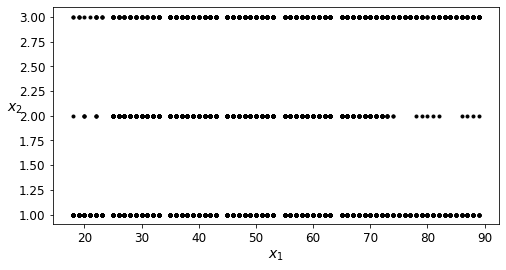

In [94]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.show()

In [95]:
k =4
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

In [96]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

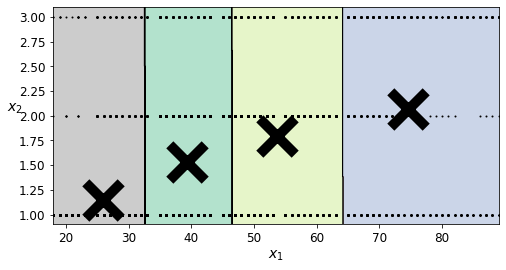

In [97]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

In [98]:
kmeans_iter1 = KMeans(n_clusters=4, init="random", n_init=1,
                     algorithm="full", max_iter=1, random_state=1)
kmeans_iter2 = KMeans(n_clusters=4, init="random", n_init=1,
                     algorithm="full", max_iter=2, random_state=1)
kmeans_iter3 = KMeans(n_clusters=4, init="random", n_init=1,
                     algorithm="full", max_iter=3, random_state=1)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', init='random', max_iter=3, n_clusters=4, n_init=1,
       random_state=1)

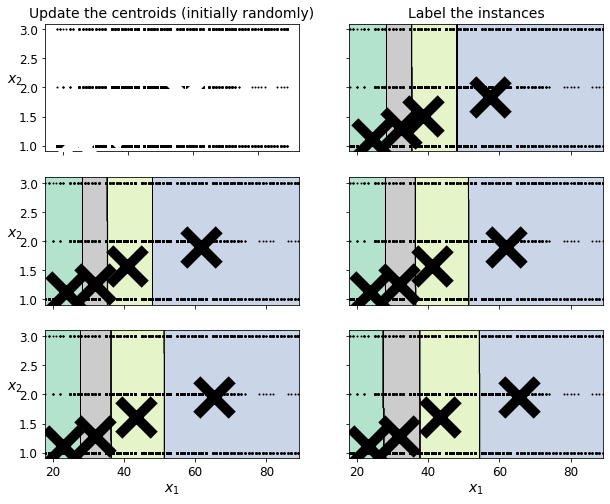

In [99]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

plt.show()

In [100]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

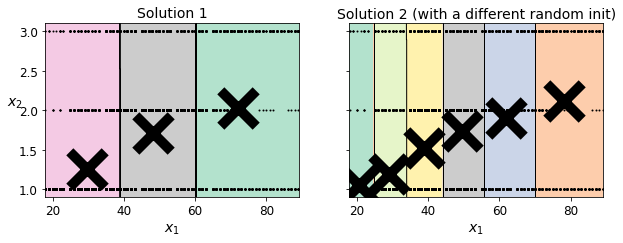

In [101]:
kmeans_rnd_init1 = KMeans(n_clusters=3, init="random", n_init=1,
                         algorithm="full", random_state=44)
kmeans_rnd_init2 = KMeans(n_clusters=6, init="random", n_init=1,
                         algorithm="full", random_state=64)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random init)")
plt.show()

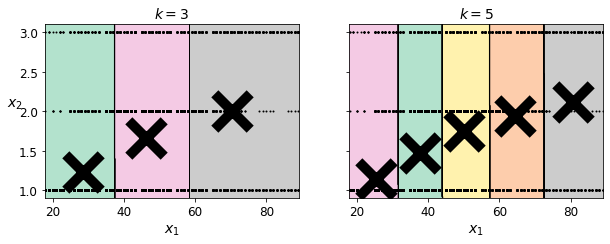

In [102]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k5 = KMeans(n_clusters=5, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k5, X, "$k=3$", "$k=5$")
plt.show()

In [103]:
kmeans_k3.inertia_

287377.81254510564

In [104]:
kmeans_k5.inertia_

107929.25159084155

In [105]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 8)]
inertias = [model.inertia_ for model in kmeans_per_k]
print(inertias)

[1908014.1294303392, 613614.8558030237, 287377.81254510564, 163268.49580423557, 107929.25159084155, 77492.30541099755, 52288.5910529466]


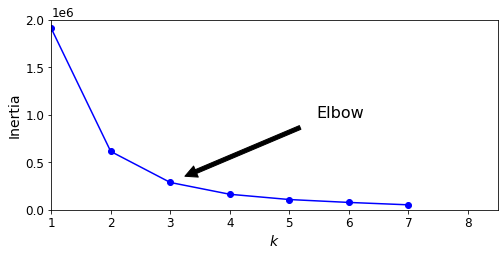

In [106]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1,8), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(3, inertias[2]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 2000000])
plt.show()